<a href="https://colab.research.google.com/github/Gayeon6423/BusinessAI-Capston/blob/main/predict_%EC%9D%B4%ED%98%81%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout, Flatten,TimeDistributed
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


stock_data = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/Final_Feature_kospi_sen_all.csv')
stock_data

,Date,Kospi_close,Kospi_high,ko_interest,oil_open,ex_JP_low,gold_low,us500_low,klue_bert_score_summarize_content,oil_vol,research_kospi,dji_vol,us500_vol,kofinbert_score_summarize_content_kospi,kofinbert_score_title_kospi,klue_bert_score_title
0,20210105,2990.57,0.795,0.0,0.213,0.590,0.661,0.581,-0.536,0.013,0.413,0.280,0.349,0.157,0.195,0.823
1,20210106,2968.21,0.819,0.0,0.219,0.596,0.650,0.585,1.381,0.006,0.628,0.470,0.527,1.236,0.569,0.722
2,20210107,3031.68,0.839,0.0,0.225,0.597,0.670,0.608,1.845,0.007,0.427,0.378,0.410,0.537,1.395,-0.675
3,20210108,3152.18,0.855,0.0,0.230,0.584,0.631,0.615,2.497,0.004,0.512,0.318,0.371,0.697,-1.382,1.124
4,20210111,3148.45,0.914,0.0,0.232,0.584,0.623,0.617,-0.951,0.009,0.881,0.287,0.334,0.331,-0.044,0.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20230623,2570.10,0.601,1.0,0.651,0.028,0.212,0.830,0.402,0.000,0.125,0.316,0.526,0.834,-0.339,0.831
584,20230626,2582.20,0.602,1.0,0.651,0.024,0.212,0.825,-0.385,0.000,0.120,0.170,0.207,-0.196,0.681,-0.001
585,20230627,2581.39,0.594,1.0,0.651,0.000,0.208,0.828,-0.447,0.000,0.118,0.206,0.226,-0.208,0.625,-0.097
586,20230628,2564.19,0.592,1.0,0.651,0.011,0.217,0.838,0.777,0.000,0.128,0.174,0.246,1.099,0.892,0.253


In [3]:
def accuracy(list1,list2):
  list1 = list1.flatten().tolist()
  list2 = list2.flatten().tolist()
  value_1 = []
  value_2 = []
  j = 0
  if len(list1) == len(list2):
    for i in range(len(list1)-1):
      if list1[i+1] > list1[i]:
        value_1.append(1)
      elif list1[i+1] == list1[i]:
        value_1.append(0)
      else:
        value_1.append(-1)
    for i in range(len(list1)-1):
      if list2[i+1] > list2[i]:
        value_2.append(1)
      elif list2[i+1] == list2[i]:
        value_2.append(0)
      else:
        value_2.append(-1)
    for i in range(len(value_1)):
      if value_1[i] == value_2[i]:
        j = j + 1
    accuracy = j/len(value_1) * 100
    print("accuracy : %d" % accuracy)
  else:
    print("길이가 다릅니다.")

In [4]:
# 데이터 전처리
data = stock_data['Kospi_close'].values.reshape(-1, 1)
stock_data = stock_data.drop(['Kospi_close'],axis=1)
stock_data = stock_data.drop(['Date'],axis=1)

In [5]:
name = [stock_data.columns]

close_1 = ['klue_bert_score_summarize_content',
        'kofinbert_score_title_kospi',
        'klue_bert_score_title']

close_2 = ['kofinbert_score_summarize_content_kospi',
        'klue_bert_score_title',
        'klue_bert_score_summarize_content']

stock_data_1 = stock_data.drop(close_1, axis=1)
stock_data_2 = stock_data.drop(close_2, axis=1)

In [6]:
# 데이터 분할
train_size = int(len(data) * 0.85)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t_1, test_data_t_1 = stock_data_1[:train_size], stock_data_1[train_size:]
train_data_t_2, test_data_t_2 = stock_data_2[:train_size], stock_data_2[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 5  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t_1, train_data, look_back)
testX, testY = create_dataset(test_data_t_1,test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(494, 5, 11)
(494, 1)
(84, 5, 11)
(84, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 1024)           3185664   
                                                                 
 dropout (Dropout)           (None, 5, 1024)           0         
                                                                 
 gru_1 (GRU)                 (None, 5, 512)            2362368   
                                                                 
 dropout_1 (Dropout)         (None, 5, 512)            0         
                                                                 
 gru_2 (GRU)                 (None, 5, 256)            591360    
                                                                 
 dropout_2 (Dropout)         (None, 5, 256)            0         
                                                                 
 gru_3 (GRU)                 (None, 5, 128)            1

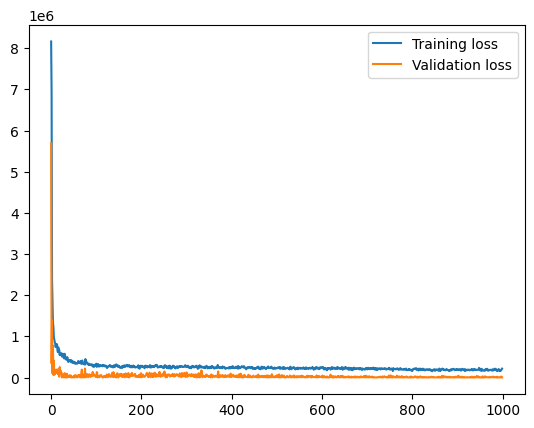

3/3 [==============================] - 0s 10ms/step
Training MSE: 5860.543628640118
Testing MSE: 2948.1239705732883
accuracy : 55


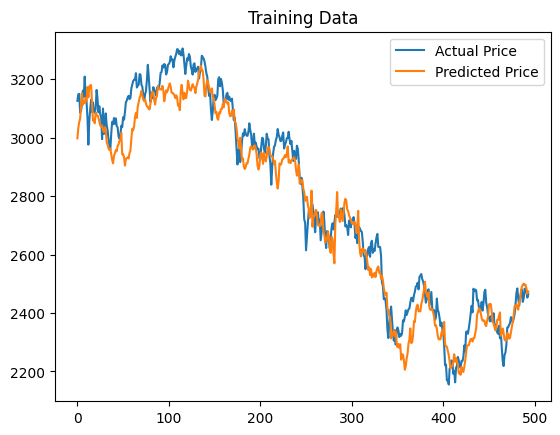

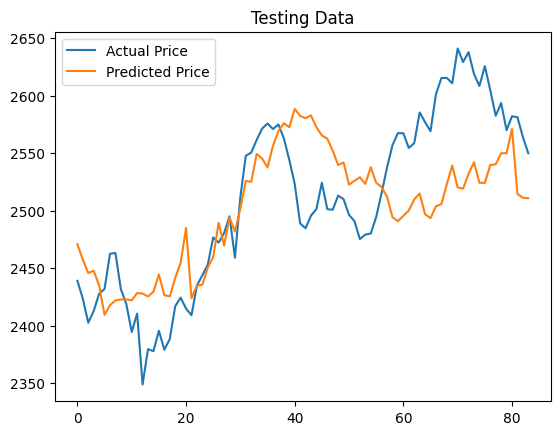

In [7]:
# 모델 생성 GRU
model = Sequential()
model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2, callbacks=[checkpoint])

model.save_weights('./ko_sum_GRU_weights.h1')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 256)            8704      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 256)            0         
 D)                                                              
                                                                 
 gru_6 (GRU)                 (None, 1, 1024)           3938304   
                                                                 
 dropout_6 (Dropout)         (None, 1, 1024)           0         
                                                                 
 gru_7 (GRU)                 (None, 1, 512)            2362368   
                                                                 
 dropout_7 (Dropout)         (None, 1, 512)            0         
                                                      

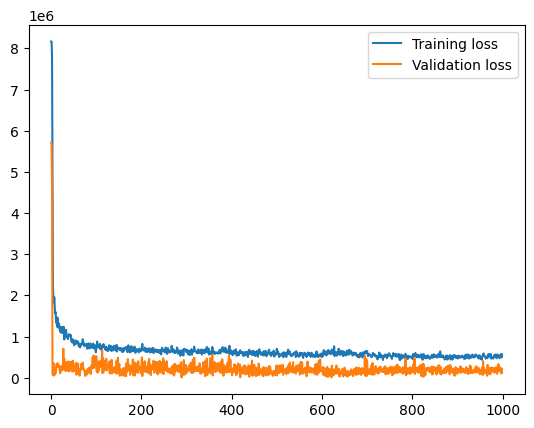

3/3 [==============================] - 0s 17ms/step
Training MSE: 32717.369734470285
Testing MSE: 3111.831486116675
accuracy : 53


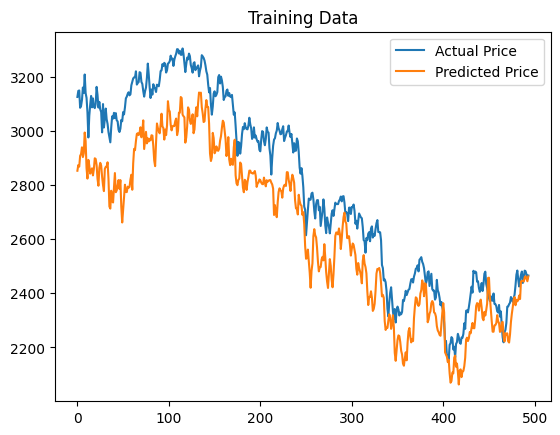

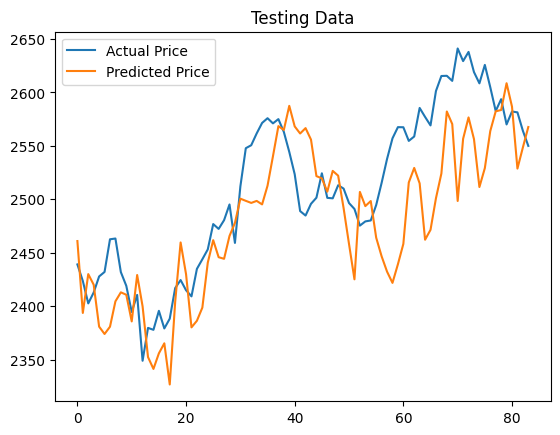

In [8]:
# 모델 생성 GRU+CNN
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./ko_sum_CNN_GRU__weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [9]:
trainX, trainY = create_dataset(train_data_t_2, train_data, look_back)
testX, testY = create_dataset(test_data_t_2,test_data, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(494, 5, 11)
(494, 1)
(84, 5, 11)
(84, 1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 1024)           4243456   
                                                                 
 dropout_13 (Dropout)        (None, 5, 1024)           0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 512)            3147776   
                                                                 
 dropout_14 (Dropout)        (None, 5, 512)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 256)            787456    
                                                                 
 dropout_15 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 128)           

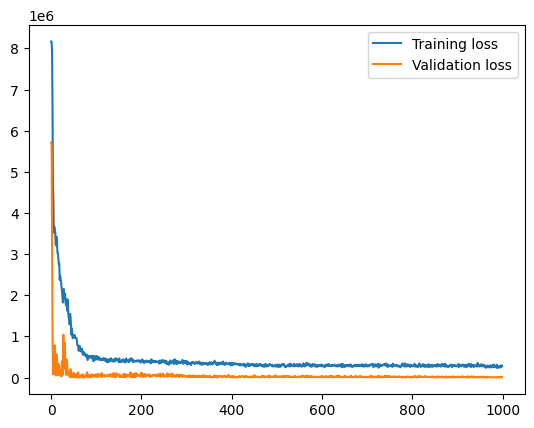

3/3 [==============================] - 0s 11ms/step
Training MSE: 6201.789733795827
Testing MSE: 4502.326964738565
accuracy : 59


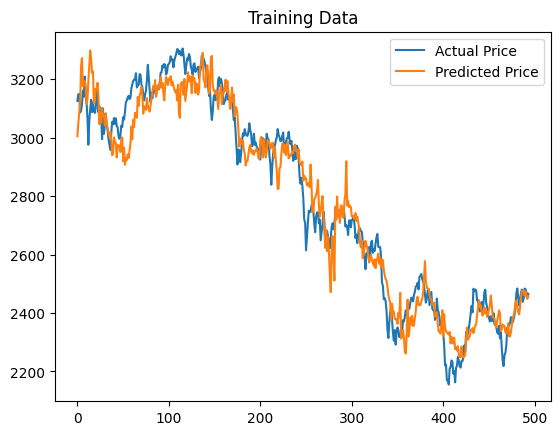

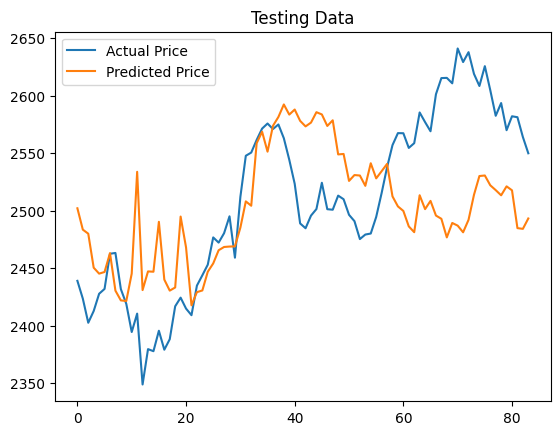

In [10]:
# 모델 생성 LSTM
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./ko_t_LSTM_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 3, 256)            8704      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1, 256)            0         
 g1D)                                                            
                                                                 
 lstm_35 (LSTM)              (None, 1, 1024)           5246976   
                                                                 
 dropout_61 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_36 (LSTM)              (None, 1, 512)            3147776   
                                                                 
 dropout_62 (Dropout)        (None, 1, 512)            0         
                                                      

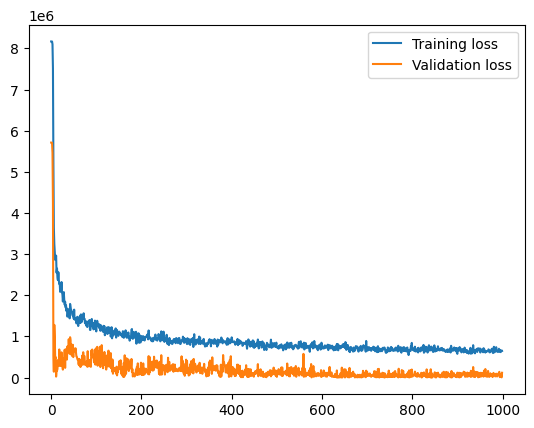

3/3 [==============================] - 0s 9ms/step
Training MSE: 12510.829129005042
Testing MSE: 1896.6402286340797
accuracy : 51


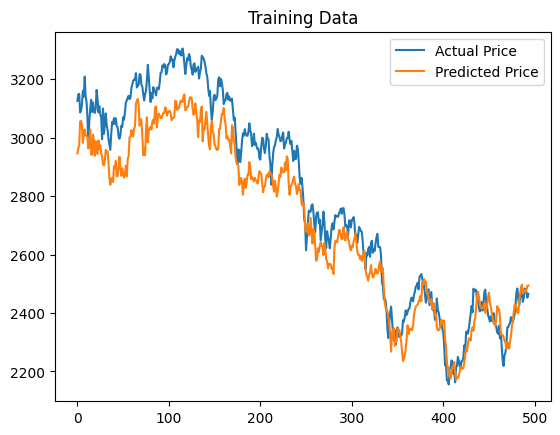

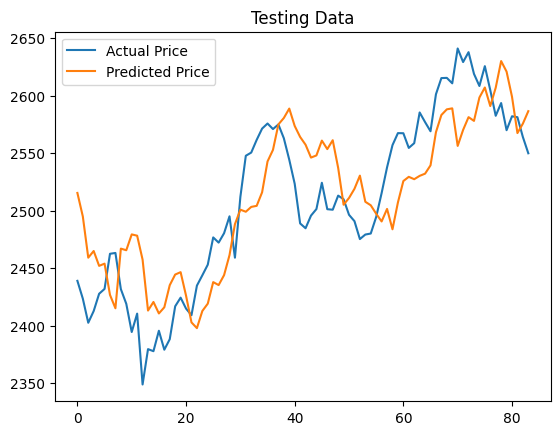

In [17]:
# 모델 생성 CNN+ LSTM
model = Sequential()
model.add(Conv1D(filters=256 , kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./ko_t_CNN_LSTM__weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_13 (GRU)                (None, 5, 1024)           3185664   
                                                                 
 dropout_27 (Dropout)        (None, 5, 1024)           0         
                                                                 
 gru_14 (GRU)                (None, 5, 512)            2362368   
                                                                 
 dropout_28 (Dropout)        (None, 5, 512)            0         
                                                                 
 gru_15 (GRU)                (None, 5, 256)            591360    
                                                                 
 dropout_29 (Dropout)        (None, 5, 256)            0         
                                                                 
 gru_16 (GRU)                (None, 5, 128)           

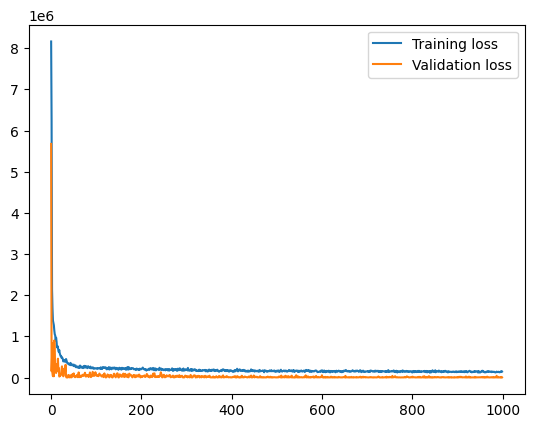

3/3 [==============================] - 0s 12ms/step
Training MSE: 18620.48911859037
Testing MSE: 5714.389952251256
accuracy : 54


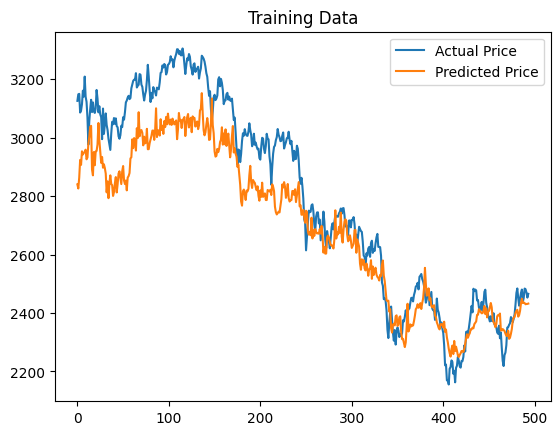

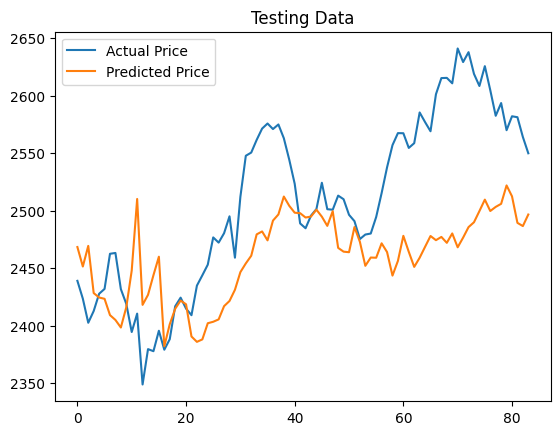

In [12]:
# 모델 생성 GRU
model = Sequential()
model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2, callbacks=[checkpoint])

model.save_weights('./ko_t_GRU_weights.h1')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3, 256)            8704      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 256)            0         
 g1D)                                                            
                                                                 
 gru_19 (GRU)                (None, 1, 1024)           3938304   
                                                                 
 dropout_33 (Dropout)        (None, 1, 1024)           0         
                                                                 
 gru_20 (GRU)                (None, 1, 512)            2362368   
                                                                 
 dropout_34 (Dropout)        (None, 1, 512)            0         
                                                      

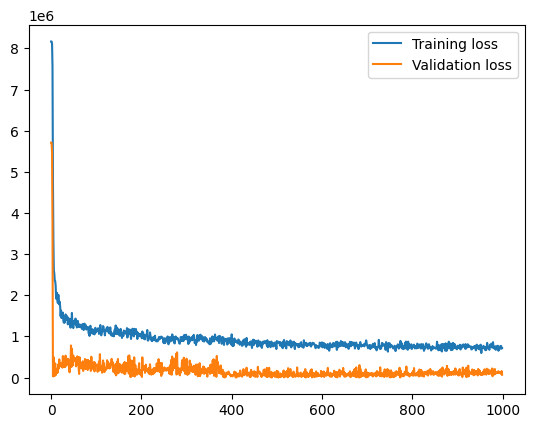

3/3 [==============================] - 0s 8ms/step
Training MSE: 32622.279815623107
Testing MSE: 2656.9074424433143
accuracy : 55


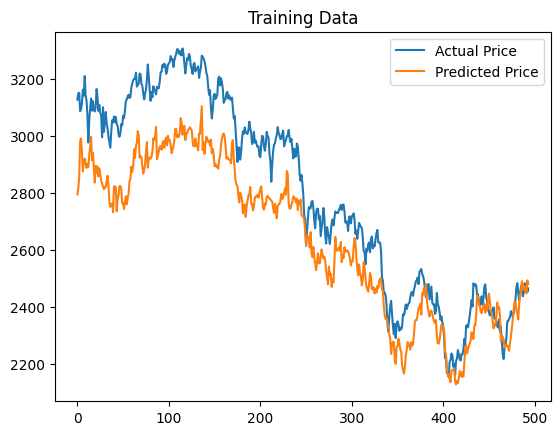

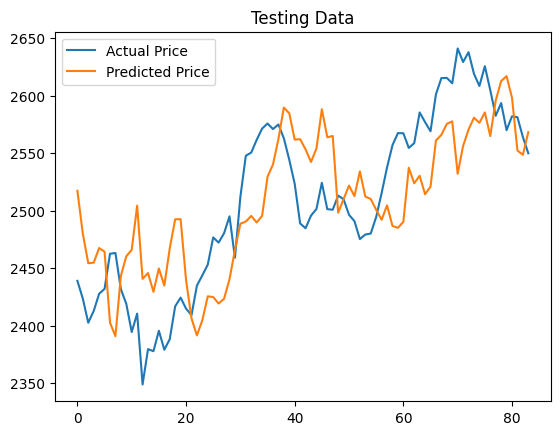

In [13]:
# 모델 생성 GRU+CNN
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./ko_t_CNN_GRU_weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

accuracy(testPredict,testY)

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()